<a href="https://colab.research.google.com/github/CRekkaran/Instant-Background/blob/master/KeyPointsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Facial Key points Detection using Pytorch/Keras

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import os

from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from keras import backend as K
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

Using TensorFlow backend.


In [2]:
!mkdir /root/.kaggle
!echo '{"username":"crekkt","key":"20605e97f88baa2a583401d4d07f2840"}' > /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

{"username":"crekkt","key":"20605e97f88baa2a583401d4d07f2840"}


In [3]:
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [4]:
!wget -P ./ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip train-test-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/Elmar_Brok_30.jpg  
  inflating: test/Elmar_Brok_31.jpg  
  inflating: test/Elsa_Zylberstein_00.jpg  
  inflating: test/Elsa_Zylberstein_01.jpg  
  inflating: test/Elsa_Zylberstein_10.jpg  
  inflating: test/Elsa_Zylberstein_11.jpg  
  inflating: test/Elsa_Zylberstein_40.jpg  
  inflating: test/Elsa_Zylberstein_41.jpg  
  inflating: test/Elton_John_10.jpg  
  inflating: test/Elton_John_11.jpg  
  inflating: test/Elton_John_20.jpg  
  inflating: test/Elton_John_21.jpg  
  inflating: test/Elton_John_30.jpg  
  inflating: test/Elton_John_31.jpg  
  inflating: test/Elton_John_40.jpg  
  inflating: test/Elton_John_41.jpg  
  inflating: test/Emile_Lahoud_00.jpg  
  inflating: test/Emile_Lahoud_01.jpg  
  inflating: test/Emile_Lahoud_30.jpg  
  inflating: test/Emile_Lahoud_31.jpg  
  inflating: test/Emile_Lahoud_40.jpg  
  inflating: test/Emile_Lahoud_41.jpg  
  inflating: test/Emilio_Botin_00.jpg  
  inflating: test/Emilio_

In [0]:
df_train = pd.read_csv('/content/training_frames_keypoints.csv')

<h4> Data Visualisation

In [0]:
im_index = 20
im_name = df_train.loc[im_index][0]

im_kp = np.array(df_train.loc[im_index][1:]).reshape(-1,2)

im = cv2.imread('./training/'+str(im_name))

for x in im_kp:
  im[int(x[1])][int(x[0])] = [255, 0, 0]

cv2_imshow(im)

# Keras Model Architecture

# <h4> Model Architecture

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        ## output size = (W-F)/S +1 = (224 - 5)/1 +1 = 220
        # after conv 1, the output Tensor for one image, will have the dimensions: (32, 220, 220)
        # after one pool layer, this becomes (32, 110, 110)
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv1_drop = nn.Dropout2d(p= 0.1)

        # second conv layer: 32 inputs, 48 outputs, 5x5 conv
        ## output size = (W-F)/S +1 = (110 - 5)/1 +1 = 106
        # the output tensor will have dimensions: (64, 106, 106)
        # after another pool layer this becomes (64, 53, 53);
        self.conv2 = nn.Conv2d(32, 48, 5)
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv2_drop = nn.Dropout2d(p= 0.1)

        # third conv layer: 64 inputs, 64 outputs, 5x5 conv
        ## output size = (W-F)/S +1 = (53 - 5)/1 +1 = 49
        # the output tensor will have dimensions: (64, 49, 49)
        # after another pool layer this becomes (64, 24, 24);
        self.conv3 = nn.Conv2d(48, 64, 5)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv3_drop = nn.Dropout2d(p = 0.2)

        # fourth conv layer: 64 inputs, 96 outputs, 5x5 conv
        ## output size = (W-F)/S +1 = (24 - 5)/1 +1 = 20
        # the output tensor will have dimensions: (96, 20, 20)
        # after another pool layer this becomes (96, 10, 10);
        self.conv4 = nn.Conv2d(64, 96, 5)
        self.conv4_bn = nn.BatchNorm2d(96)
        self.conv4_drop = nn.Dropout2d(p = 0.2)

        self.fc1 = nn.Linear(96*10*10, 96*5*5)
        self.fc1_bn = nn.BatchNorm1d(96*5*5)
        
        # dropout with p=0.2
        self.fc1_drop = nn.Dropout(p=0.2)

        self.fc2 = nn.Linear(96*5*5, 68*3*3)
        self.fc2_bn = nn.BatchNorm1d(68*3*3)

        # dropout with p=0.3
        self.fc2_drop = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(68*3*3, 68*2)
        
        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))
      
        x = F.relu(F.max_pool2d(self.conv1_bn(self.conv1(x)),2))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)),2))
        x = self.conv2_drop(x)
        x = F.relu(F.max_pool2d(self.conv3_bn(self.conv3(x)),2))
        x = self.conv3_drop(x)
        x = F.relu(F.max_pool2d(self.conv4_bn(self.conv4(x)),2))
        x = self.conv4_drop(x)

        # prep for linear layer
        x = x.view(x.size(0), -1)
        
        # fc 1
        x = self.fc1_drop(F.relu(self.fc1_bn(self.fc1(x))))
        
        # fc 2
        x = self.fc2_drop(F.relu(self.fc2_bn(self.fc2(x))))
        
        # fc 3
        x = self.fc3(x)
        # a modified x, having gone through all the layers of your model, should be returned
        return x

# <h4> Dataset class

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.image as mpimg

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

# tranforms
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [10]:
data_transform = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


# <h4>Loading Training Data

In [0]:
batch_size = 32

# create transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./training_frames_keypoints.csv',
                                      root_dir='./training/', transform=data_transform)

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

# <h4> Loading Testing Data

In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./test_frames_keypoints.csv',
                                             root_dir='./test/',
                                             transform=data_transform)

# load test data in batches
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
net = Net().to(device)

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

# Debugging

In [0]:
test_images.data = test_images.data.to(device)

In [21]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


# Loss function

In [0]:
import torch.optim as optim
# criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [0]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 20 == 19:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [27]:
# train your network
n_epochs = 300
train_net(n_epochs)

Epoch: 1, Batch: 20, Avg. Loss: 0.00816324995458126
Epoch: 1, Batch: 40, Avg. Loss: 0.005085300013422966
Epoch: 1, Batch: 60, Avg. Loss: 0.004776018738746643
Epoch: 1, Batch: 80, Avg. Loss: 0.0042289370000362396
Epoch: 1, Batch: 100, Avg. Loss: 0.003795720458030701
Epoch: 2, Batch: 20, Avg. Loss: 0.0032061498612165453
Epoch: 2, Batch: 40, Avg. Loss: 0.003109279975295067
Epoch: 2, Batch: 60, Avg. Loss: 0.003769123710691929
Epoch: 2, Batch: 80, Avg. Loss: 0.0030027052089571953
Epoch: 2, Batch: 100, Avg. Loss: 0.002942018553614616
Epoch: 3, Batch: 20, Avg. Loss: 0.002995471827685833
Epoch: 3, Batch: 40, Avg. Loss: 0.0024775629118084907
Epoch: 3, Batch: 60, Avg. Loss: 0.002413270629942417
Epoch: 3, Batch: 80, Avg. Loss: 0.0023321392461657523
Epoch: 3, Batch: 100, Avg. Loss: 0.0019871929660439493
Epoch: 4, Batch: 20, Avg. Loss: 0.002037954866886139
Epoch: 4, Batch: 40, Avg. Loss: 0.002007963925600052
Epoch: 4, Batch: 60, Avg. Loss: 0.0017588642388582229
Epoch: 4, Batch: 80, Avg. Loss: 0.001

<h2> Testing

In [28]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


# <h3> Visualise Image

In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

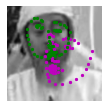

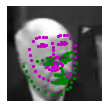

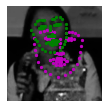

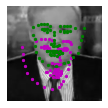

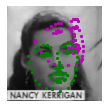

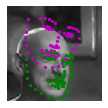

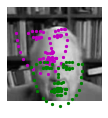

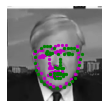

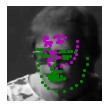

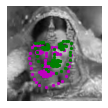

In [33]:
import matplotlib.pyplot as plt
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i+20].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [0]:
model_dir = './'
model_name = 'karan_keypoints_model_2.pt'
torch.save(net.state_dict(), model_dir+model_name)

In [94]:
# my photo
# !wget https://lh3.googleusercontent.com/pw/ACtC-3eNkfsMa5xLjo_9zrtHgKZVqXuZjHtoRd6rDKruwzXMNx9BL8owYPYUwhWEDLBMuJlUx1Xp5ra2xfWGdMpGX-9LAc8J5zJqPhg3qRxxtl-GJzNGJPbzjlH5j39RfzmhyiyzhGxHB4cB0CB1p6Mby-fa=w493-h657-no?authuser=0
!wget https://photos.google.com/share/AF1QipPVm40bX3p9R-n3xQoLj8BP_pXiPULMSZTTkzuH3oCqEq6Lf7eGhLW1UwIqia6UIg/photo/AF1QipN45xqWOXlRjG8rRW8BFRmRGGZzalmojQgw_D0?key=bzQyVW43VU9tZ2VvNWY4Y0Zpem5ydnNMN1EtczdB

--2020-06-12 19:15:41--  https://photos.google.com/share/AF1QipPVm40bX3p9R-n3xQoLj8BP_pXiPULMSZTTkzuH3oCqEq6Lf7eGhLW1UwIqia6UIg/photo/AF1QipN45xqWOXlRjG8rRW8BFRmRGGZzalmojQgw_D0?key=bzQyVW43VU9tZ2VvNWY4Y0Zpem5ydnNMN1EtczdB
Resolving photos.google.com (photos.google.com)... 173.194.76.102, 173.194.76.138, 173.194.76.100, ...
Connecting to photos.google.com (photos.google.com)|173.194.76.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘AF1QipN45xqWOXlRjG8rRW8BFRmRGGZzalmojQgw_D0?key=bzQyVW43VU9tZ2VvNWY4Y0Zpem5ydnNMN1EtczdB’

AF1QipN45xqWOXlRjG8     [  <=>               ] 558.21K  1.74MB/s    in 0.3s    

2020-06-12 19:15:42 (1.74 MB/s) - ‘AF1QipN45xqWOXlRjG8rRW8BFRmRGGZzalmojQgw_D0?key=bzQyVW43VU9tZ2VvNWY4Y0Zpem5ydnNMN1EtczdB’ saved [571608]



# Adding test image

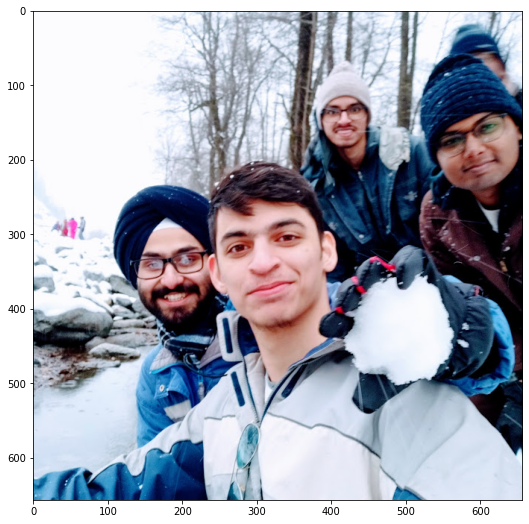

In [95]:
# load in color image for face detection
image = cv2.imread('./group.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

orig_image = image.copy()

In [38]:
!wget https://github.com/dilippatlolla/P1_Facial_Keypoints-master/blob/master/detector_architectures/haarcascade_frontalface_default.xml

--2020-06-12 18:03:52--  https://github.com/dilippatlolla/P1_Facial_Keypoints-master/blob/master/detector_architectures/haarcascade_frontalface_default.xml
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal     [  <=>               ]   8.24M  37.9MB/s    in 0.2s    

2020-06-12 18:03:54 (37.9 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [8635558]



In [0]:
!pip install git+git://github.com/PnS2019/pnslib.git

# haar cascade face recognition

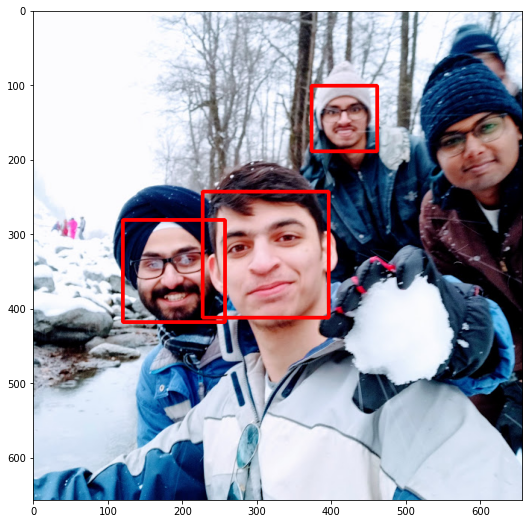

In [101]:
import cv2
from pnslib import utils
# load in a haar cascade classifier for detecting frontal faces
# face_cascade = cv2.CascadeClassifier('data/haarcascades/haarcascade_frontalface_alt.xml')
face_cascade = cv2.CascadeClassifier(utils.get_haarcascade_path('haarcascade_frontalface_default.xml'))

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [53]:
# going into evaluation mode
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_drop): Dropout2d(p=0.1, inplace=False)
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.1, inplace=False)
  (conv3): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_drop): Dropout2d(p=0.2, inplace=False)
  (conv4): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=9600, out_features=2400, bias=True)
  (fc1_bn): BatchNorm1d(2400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_drop): Dropout(p=0.

In [0]:
def show_all_keypoints(image, predicted_key_pts, ax):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    #plt.scatter(x=predicted_key_pts[:,0], y=predicted_key_pts[:,1], c='r', s=20)

    plt.scatter(x = predicted_key_pts[:, 0],y= predicted_key_pts[:, 1], s=30, marker='.', c='m')
    plt.show()

373 101 88 88
(108, 108, 3)
torch.Size([1, 1, 224, 224])


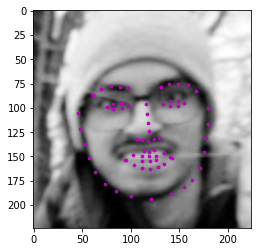

227 243 169 169
(189, 189, 3)
torch.Size([1, 1, 224, 224])


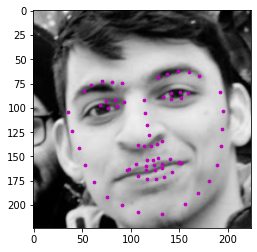

120 281 137 137
(157, 157, 3)
torch.Size([1, 1, 224, 224])


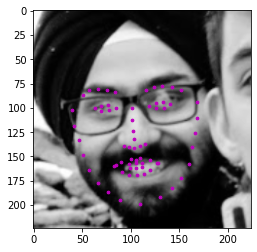

In [110]:
image_copy = np.copy(image)
ax = [0]*faces.shape[0]
fig, ax = plt.subplots()

padding_w = 10
padding_h = 10
# loop over the detected faces from your haar cascade
i =0
points = []
for (x,y,w,h) in faces:
  print(x,y,w,h)
  # Select the region of interest that is the face in the image 
  roi = image_copy[y-padding_h:y+h+padding_h, x-padding_w:x+w+padding_w]
  print(roi.shape)    
  ## TODO: Convert the face region from RGB to grayscale
  image_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
      
  ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
  image_gray=  image_gray/255.0
  
  ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
  img = cv2.resize(image_gray, (224, 224))
      
  ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
  img_reshaped = img.reshape(img.shape[0], img.shape[1], 1)
  img_reshaped = img_reshaped.transpose((2, 0, 1))
  torch_image = torch.from_numpy(img_reshaped)
  # TODO: Make facial keypoint predictions using your loaded, trained network 
  ## perform a forward pass to get the predicted facial keypoints
  torch_image.unsqueeze_(0)
  torch_image = torch_image.type(torch.cuda.FloatTensor)


  print(torch_image.data.size())

  predicted_key_pts = net(torch_image)
  predicted_key_pts = predicted_key_pts.detach().cpu().numpy()

  predicted_key_pts = predicted_key_pts*50.0 + 100
  predicted_key_pts =  predicted_key_pts.reshape(68,2)
  points.append(predicted_key_pts)
  ## TODO: Display each detected face and the corresponding keypoints        
  show_all_keypoints(np.squeeze(img),predicted_key_pts, plt)
  i = i + 1


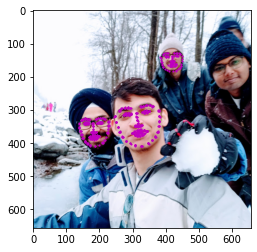

In [111]:
# display key points overlaid on the original image

plt.imshow(orig_image, cmap='gray')

for index,(x,y,w,h) in enumerate(faces):
    
    # print(x,y,w,h)
    
    # Select the region of interest that is the face in the image
    # i used padding_w = padding_h = 60
    
    # get roi 
    roi = image_copy[y-padding_h:y+h+padding_h, x-padding_w:x+w+padding_w]
    
    # create a blank cv2 image with dimensions of out input image 224x224
    blank_image = np.zeros((224,224,3), np.uint8)
    
    # create a dest blank image to save the key points in the =resized roi size
    dest_image = np.zeros(roi.shape, np.uint8)

    # convert keypoints to ints
    # points[0] has Obama face keypoints and points[1]: Michelle
    int_points = points[index].astype(int)
    
    # update blank image with pixel value 255 for the indicies of keypoints
    blank_image[int_points[:,0],int_points[:,1],0] = 255
    
    # create a resized array of size (y+h+padding_h - (y-padding_)) and (x+w+padding_w - (x-padding_w))
    # for Barack its 294x294 and Michelle its 280x280
    # then resize the blank_image with keypoitns to the new size
    resized_roi = cv2.resize(blank_image, (w + 2 * padding_w, h + 2* padding_w),interpolation = cv2.INTER_CUBIC)

    # transpose the dest image due to cv2 origin
    cv2.transpose(resized_roi, dest_image)    

    numpy_resized = np.asarray(dest_image)
    
    # get all resized keypoints from the resized image.
    # these should be where all the pixel values are greater than 0
    resized_key_points = np.asarray(np.where(dest_image[:,:,0] > 0))
    
    # update the resized 2d points to translate them
    resized_key_points[0,:] = resized_key_points[0,:] + y - padding_w
    resized_key_points[1,:] = resized_key_points[1,:] + x - padding_h

    plt.scatter(x = resized_key_points[1, :] ,y= resized_key_points[0, :], s=5, marker='.', c='m')


# Visualise Filter

[[ 0.02636033  0.06525263  0.04347866  0.10098128  0.01048421]
 [ 0.13387494 -0.02528124  0.2856039   0.10745741  0.24281703]
 [-0.00450677  0.11722963  0.02672035  0.11694992  0.00876812]
 [-0.04345873  0.00348117 -0.15253948 -0.17186666 -0.09044139]
 [-0.17007932 -0.3865653  -0.36226735 -0.18102068 -0.4558743 ]]
(5, 5)


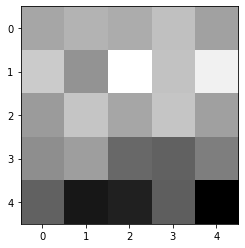

In [42]:
weights1 = net.conv1.weight.data
w = weights1.cpu().numpy()
filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

# Extracting model from Drive

In [0]:
!cp ./drive/My\ Drive/karan_keypoints_model_1.pt ./
model = Net()
file_path = './karan_keypoints_model_1.pt'
model.load_state_dict(torch.load(file_path))
model.eval()

# Prediction for One test example

In [0]:
def predict_one(filename):
  me = mpimg.imread(filename)
  me = cv2.resize(me, (250, 250))
  im_copy = np.copy(me)
  im_copy = cv2.cvtColor(me, cv2.COLOR_RGB2GRAY)
  im_copy = (im_copy/255.0)

  if(len(im_copy.shape) == 2):
      im_copy = im_copy.reshape(im_copy.shape[0], im_copy.shape[1], 1)
      
  im_copy = im_copy.transpose((2, 0, 1))
  im_copy = im_copy.reshape(1, 1, 250, 250)

  # PREDICTION
  temp = torch.from_numpy(im_copy).float().cuda()
  key_points = net(temp)

  # RESIZE Key POINTS and IMAGE
  image = me
  # un-transform the predicted key_pts data
  predicted_key_pts = key_points[0].data
  predicted_key_pts = predicted_key_pts.cpu().numpy()
  # undo normalization of keypoints  
  predicted_key_pts = predicted_key_pts*50.0+100
  kp = predicted_key_pts.reshape(-1, 2)
  kp = kp.astype('int32')

  #PLOT FACE AND KEY POINTS
  plt.imshow(np.squeeze(im_copy), cmap='gray')
  plt.scatter(kp[:, 0], kp[:, 1], s=20, marker='.', c='m')
  plt.show()